## ProxyStore performance benchmarks
All measurements recorded here were taken on Chameleon Cloud TACC `compute-ib-haswell` nodes configured with Centos 7. 
Node configuration scripts can be found in the `~/configuration` folder, whereas the benchmarking scripts can be found in the current (`~/benchmark`) folder.

Each experimental condition was repeated 10x.

### Data imports

In [1]:
import seaborn as sns
import pandas as pd

df_local = pd.read_csv("results/local.log", header=0)
df_remote = pd.read_csv("results/remote.log", header=0)

### Plot functions

In [2]:
# all the plot functions
from typing import Literal, Tuple, Optional
from math import log10 as log
import matplotlib.pyplot as plt
import numpy as np

color_mapping = { 
    'local': sns.color_palette("colorblind")[0],
    'file': sns.color_palette("colorblind")[1],
    'redis': sns.color_palette("colorblind")[2],
    'keydb': sns.color_palette("colorblind")[3],
    'globus': sns.color_palette("colorblind")[6],
    'rdma': sns.color_palette("colorblind")[8]
}

def format_str(df, index=None):
    if index is not None:
        return ''.join(f"{k}: {v[index]}\n" for k,v in df.to_dict().items())
    return ''.join(f"{k}: {v}\n" for k,v in df.to_dict().items())

def gen_stats(min_str, max_str, avg_str, stdev_str):
    print("***Stats***")
    print(f"Min runtime (s):\n{min_str}")
    print(f"Max runtime (s):\n{max_str}")
    print(f"Avg runtime (s):\n{avg_str}")
    print(f"Standard deviation of runtime (s):\n{stdev_str}")

def connection_bar(df, print_stats=False):
    df.loc[df["function"] == "RDMAStore", "function"] = "init_store"
    connect_df = df[df["function"] == "init_store"]
    ax = sns.barplot(x="store", y="duration", data=connect_df, palette=color_mapping)
    ax.set(xlabel="Store", ylabel="Duration (s)")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()
    
    st_d = connect_df.pivot_table(
        index="function",
        columns="store",
        values="duration"
    ).groupby("function")

    idx_val = "init_store"
    min_str = format_str(st_d.min(), idx_val)
    max_str = format_str(st_d.max(), idx_val)
    avg_str = format_str(st_d.mean(), idx_val)
    stdev_str = format_str(st_d.std(), idx_val)
    
    if print_stats:
        gen_stats(min_str, max_str, avg_str, stdev_str)
    
def transfer_plot(
    df: pd.DataFrame,
    task: Literal["store_data", "load_proxy", "load_proxy_cached"],
    exp_range: Optional[Tuple[int, int]]=None,
    print_stats: bool=False,
    bbox_x: float=1,
):
    pd.options.mode.chained_assignment = None
    
    io_df = df[df["function"] == task]
    io_df["size_exp"] = io_df["size"].apply(lambda x: log(x) /  log(2)).astype(int)
    #io_df["size_str"] = io_df["size_exp"].apply(lambda x: "$\mathregular{" + "2^{" + str(x) + "}}$")
    
    if exp_range is not None:
        io_df = io_df.loc[(io_df["size_exp"] >= exp_range[0])
                          & (io_df["size_exp"] < exp_range[1])]
        
    ax = sns.barplot(
        x="size_exp",
        y="duration",
        hue="store",
        data=io_df,
        palette=color_mapping
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set(xlabel="Transfer size ($\mathregular{2^n}$ bytes)", ylabel="Duration (s)")
    ax.legend(bbox_to_anchor=(bbox_x, 1.05), title="Store")

    plt.show()
        
    pivot_df = io_df.pivot_table(index="size_exp",
                                 columns="store",
                                 values="duration",
                                 aggfunc=[np.min, np.max, np.mean, np.std])
    
    min_str = format_str(pivot_df.min()["amin"])
    max_str = format_str(pivot_df.max()["amax"])
    avg_str = format_str(pivot_df.mean()["mean"])
    stdev_str = format_str(pivot_df.std()["std"])
    
    if print_stats:
        gen_stats(min_str, max_str, avg_str, stdev_str)


### Local benchmarks
All the following benchmarks were taken on a single node. That is, all endpoints were located on the same node and there was no network communication involvement.

#### Connection time latency

The figure below tests the latency of simply initializing the store.
We notice that all store latencies are relatively small.

LocalStore has the smallest latency, due to only creating an empty dictionary.

FileStore is the next fastest, querying the filesystem for the existence of the store folder.

Redis and KeyDB are the slowest, leveraging the same API (redis-python) to connect to their local endpoints.

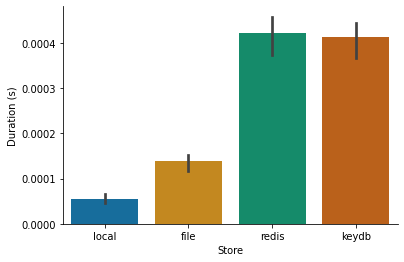

In [3]:
connection_bar(df_local)

#### Write benchmarks

For these benchmark, a string of a's of a certain byte size is stored in the provided store. 
We observe that LocalStore is the fastest at writing, regardless of data size, as it only needs to write to a Python dictionary. 
File, Redis and KeyDB all perform comparably and remarkably worse than LocalStore, particularly with larger file sizes. This is likely due to Redis and KeyDB's copy-on-write functionality thus requiring all Stores to write to the local filesystem.

KeyDB appears to be slightly worse than Redis with larger files. Unclear why.

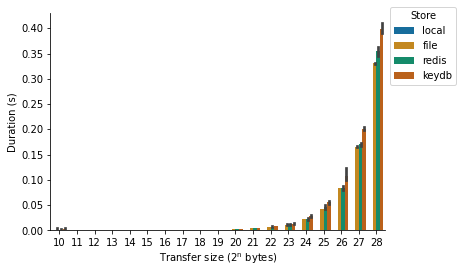

In [4]:
transfer_plot(df_local, "store_data")

When we zoom into the smaller file transfers, FileStore write performance seems to be extremely variable. Something not apparent with the other stores.

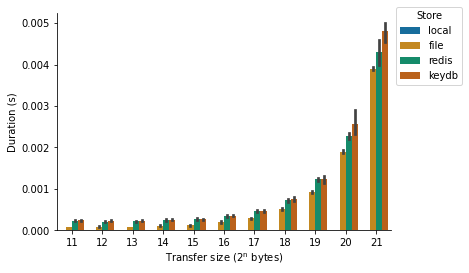

In [5]:
transfer_plot(df_local, "store_data", (11, 22))

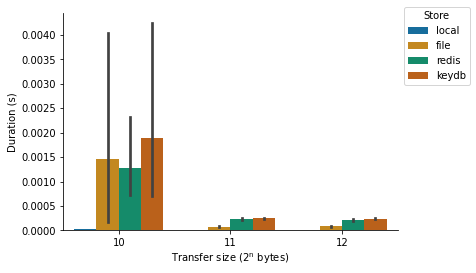

In [6]:
transfer_plot(df_local, "store_data", (10, 13), bbox_x=1.23)

### Cached read benchmarks

The goal of these benchmarks are just to ensure that all Stores behave comparably,
given that the data should all be read from the internal LRU cache and not fetched from the
store.

To execute this experiment, the recently stored data is access without any cache evictions
(except for those performed internally by the LRU cache when the cache exceeds > 16 entries)

The results below show that read times are comparably low for all stores, with the exception
of at $2^{10}$ bytes and $2^{24}$ bytes. I predict some eviction has been performed
here due to the high variability, but it remains to be investigated.

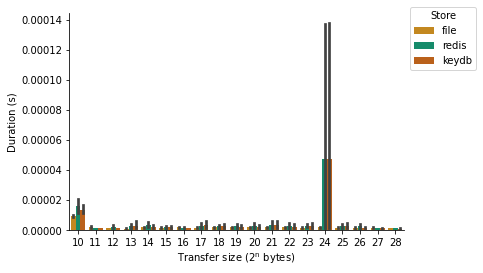

In [7]:
transfer_plot(df_local, "load_proxy_cached", bbox_x=1.23)

### (Uncached) read benchmarks

In these benchmarks, we attempt to remove the data previously stored from cache, by evicting
the data from the ProxyStore LRU cache, invoking Python garbage collection and attempting to
clear the Page Cache on the client.

As expected, the LocalStore is the fastest with reads as it is just reading from a Python
dictionary. FileStore, Redis and KeyDB all appear to perform comparably, which is surprising
as the latter two Stores should be reading from memory whereas FileStore should be reading
from the local filesystem. There are potentially still caching effects at play.

1KB writes take the longest to read for all Stores --> why??

Other than 1KB, data size does not appear to factor in to read time --> cache??

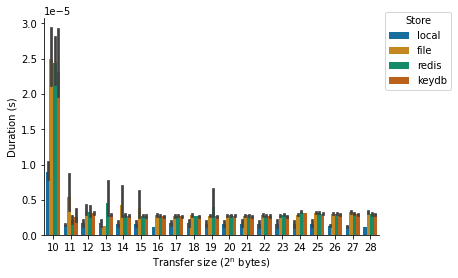

In [8]:
transfer_plot(df_local, "load_proxy", bbox_x=1.23)

## Remote store benchmarks

In these benchmarks, we compare Redis, KeyDB, Globus and Mochi+Redis (Mochi) located
on a remote node.

Benchmarks are all performed on node-1, whereas Redis, KeyDB and Mochi+Redis server are all
located on node-2. Globus has endpoints on node-1 and node-2 due to ProxyStore's requirement to
have a minimum of two Globus endpoints.

The experiments themselves are otherwise identical to that of the local experiments

### Connection time latency

Redis and KeyDB exhibit comparable performance, as with the local experiments. Globus
connection time is considerably longer, potentially due to authentication over the network.
RDMA (Mochi + Redis) is by far the slowest to connect, but also exhibits extremely variable
connection latencies. This needs to be further investigated.

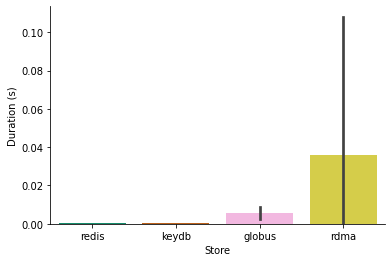

In [9]:
connection_bar(df_remote)

### Write benchmarks

Similarly to the local benchmarks, durations at 1KB are slower than at some larger sizes.

Globus is generally much slower than the other Stores, likely a result of the amount of communication involved. Globus fares much better at larger data sizes.

RDMA (mochi+Redis) is by far the slowest and remains to be investigated. Theories for why its slower include:
- unoptimal code
- not actually leveraging RDMA
- needless serialization


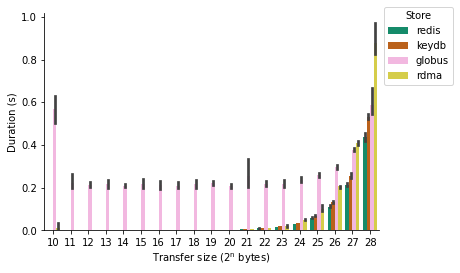

In [10]:
transfer_plot(df_remote, "store_data")

### Cached read benchmarks
These results appear to be very similar to the local benchmarks,
which is expected as the data should be read entirely from cache.

Still need to investigate why 1KB reads are longer than all other reads and whether data has
been uncached in some cases.

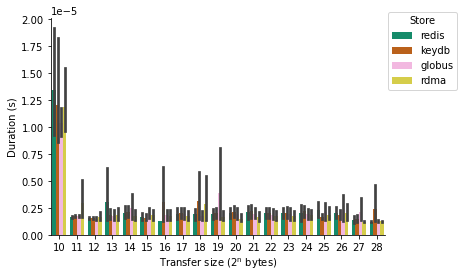

In [11]:
transfer_plot(df_remote, "load_proxy_cached", bbox_x=1.23)

### (Uncached) read benchmarks

Again, we see the 1KB remote reads have significant overheads compared to other data read
sizes.
As with the local benchmarks, data size does not affect read times and read times are
comparable for all stores.

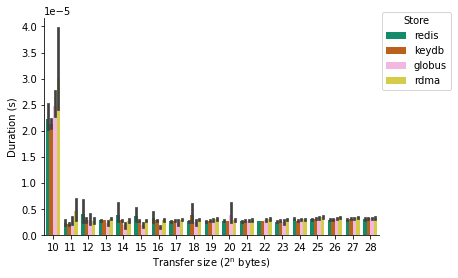

In [12]:
transfer_plot(df_remote, "load_proxy", bbox_x=1.23)